In [1]:
from dolfin import *
import numpy as np
from matplotlib import pyplot as plt


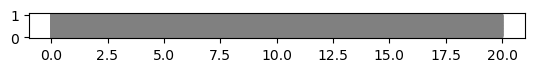

In [2]:
# path  = "/Users/1321143263qq.com/Dropbox/ScientificProject/1PaperProject/2023/Cassini_oval/results/fem_solutions/full_geo_degin/save_xml_mesh_case2"
# # load the mesh from file
# mesh = Mesh(path+"/mesh13.xml");
path = "/Users/1321143263qq.com/Dropbox/ScientificProject/1PaperProject/2023/Cassini_oval/results/fem_solutions/fenics_x_python"
mesh = RectangleMesh(Point(0, 0), Point(20 ,1), 30, 30)

coordinates = mesh.coordinates()
x_min, y_min = np.amin(coordinates, axis=0)[:2]
x_max, y_max = np.amax(coordinates, axis=0)[:2]
def left_boundary(x, on_boundary):
    return on_boundary and abs(x[0] - x_min) < DOLFIN_EPS


def right_boundary(x, on_boundary):
    return on_boundary and abs(x[0] - x_max) <DOLFIN_EPS
def top_boundary(x, on_boundary):
    return on_boundary and abs(x[1] - y_max) < DOLFIN_EPS
def bottom_boundary(x, on_boundary):
    return on_boundary and abs(x[1] - y_min) < DOLFIN_EPS
plot(mesh)

# Define the function 
## Plain strain model:

$\lambda = \frac{ \nu E}{(1+\nu)(1-2\nu)}$

$\mu =\frac{E}{2(1+\nu)}$

## Plain stress model
$\hat{\lambda} = \frac{2\mu\lambda}{\lambda +2\mu}$

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 0.000e+00 (tol = 1.000e-10) r (rel) = nan (tol = 1.000e-09)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.366e+06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.421e+04 (tol = 1.000e-10) r (rel) = 1.041e-02 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 9.552e+01 (tol = 1.000e-10) r (rel) = 6.993e-05 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 2.160e+01 (tol = 1.000e-10) r (rel) = 1.581e-05 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 3.315e-04 (tol = 1.000e-10) r (rel) = 2.427e-10 (tol = 1.000e-09)
  Newton solver finished in 4 iterations and 4 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.844e+06 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 2.248e+04 (tol = 1.000e-1

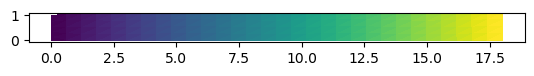

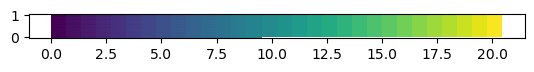

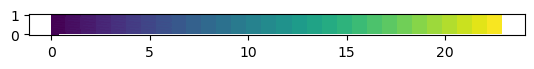

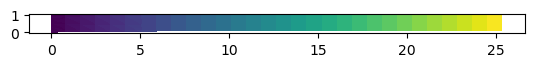

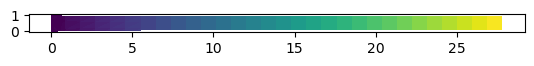

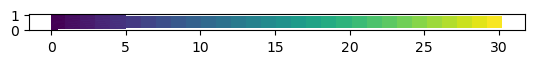

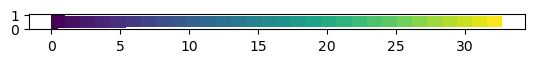

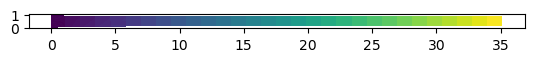

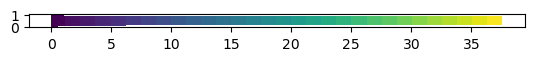

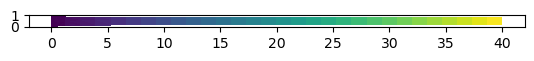

In [3]:
V = VectorFunctionSpace(mesh, "CG", 1)

# Define Dirichlet boundary(fixed both x and y directon deformation)
bc_left = DirichletBC(V, Constant((0.0, 0.0)), left_boundary)  # Fixed displacement

# Define Dirichlet bondary(only fixed x direction deformation)
# bc_left = DirichletBC(V.sub(0),Constant(0.0),left_boundary);
bc_top = DirichletBC(V.sub(1), Constant(0.0), top_boundary)


# Define Neumann boundary
# zero traction on the right side
g = Constant((0.0, 0.0))


# Define functions
du = TrialFunction(V)  # Incremental displacement
v = TestFunction(V)  # Test function
u = Function(V)  # Displacement from previous iteration
# Kinematics
d = u.geometric_dimension()
I = Identity(d)  # Identity tensor
F = I + grad(u)  # Deformation gradient

# --------------------
# Weak form
# --------------------
# Invariants of deformation tensors C
C = F.T * F
Ic = tr(C)
J = det(F)

# Elasticity parameters
E, nu = 1e6, 0.3

# plain strain assumption
mu, lmbda = Constant(E/(2*(1 + nu))), Constant(E*nu/((1 + nu)*(1 - 2*nu)))

# Neo-Hookean model
psi = (mu / 2) * (Ic - 2) - mu * ln(J) + (lmbda / 2) * (ln(J))**2

# Total potential energy
Pi = psi * dx

# Compute first variation of Pi (directional derivative)
F = derivative(Pi, u, v)

# Compute Jacobian of F
Jacobian = derivative(F, u, du)


# Solve problem
bc_right = DirichletBC(V.sub(0), Constant(200), right_boundary) # ux= variable;
# bc = [bc_left, bc_right]
problem = NonlinearVariationalProblem(F, u, bc_left, Jacobian)
solver = NonlinearVariationalSolver(problem)

# Set solver parameters (if needed)
solver.parameters["newton_solver"]["linear_solver"] = "lu"
solver.solve()

# Incremental loading


num_steps = 10
init_deformation = -0.1*x_max# Initial imposed deformation
final_deformation = 1*x_max # Final imposed deformation

deformation_increment = np.linspace(init_deformation, final_deformation, num_steps)

# FUNCTION:  meausre the force on the right boundary
def force_measure(u):
    F = Identity(2) + grad(u)
    E = 0.5 * (F.T * F - Identity(2))
    sigma = 2.0 * mu * E + lmbda * tr(E) * Identity(2)
    boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
    boundary_markers.set_all(0)  # Initialize with default value 0
    right_bndry = AutoSubDomain(lambda x, on_boundary: near(x[0], x_max) and on_boundary)
    right_bndry.mark(boundary_markers, 1)  # Mark the right boundary with value 1
    ds_right = Measure("ds", domain=mesh, subdomain_data=boundary_markers, subdomain_id=1)
    force = assemble(dot(sigma, FacetNormal(mesh))[0] * ds_right(1))
                           
    return force
def normal_stress_measure(u):
    F = Identity(2) + grad(u)
    E = 0.5 * (F.T * F - Identity(2))
    sigma = 2.0 * mu * E + lmbda * tr(E) * Identity(2)
    boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
    boundary_markers.set_all(0)  # Initialize with default value 0
    right_bndry = AutoSubDomain(lambda x, on_boundary: near(x[0], x_max) and on_boundary)
    right_bndry.mark(boundary_markers, 1)  # Mark the right boundary with value 1
    ds_right = Measure("ds", domain=mesh, subdomain_data=boundary_markers, subdomain_id=1)
    normal_stress = dot(sigma, FacetNormal(mesh))  # Compute the dot product of sigma with the facet normal
    normal_stress_component = normal_stress[0]  # Extract the normal stress component in the x-direction
    # normal_stress_component = normal_stress[1]  # Extract the normal stress component in the y-direction    
    normal_stress_avg = assemble(normal_stress_component * ds_right(1)) / assemble(Constant(1.0) * ds_right(1))
    return normal_stress_avg



foce_on_right= [];
normal_stress_on_right = [];
for step in range(num_steps):
    # Update right boundary condition
    bc_right = DirichletBC(V.sub(0), Expression("var", var=deformation_increment[step], degree=1), right_boundary)
    bcs = [bc_left, bc_right]
    problem = NonlinearVariationalProblem(F, u, bcs, Jacobian,form_compiler_parameters={"optimize": True})
    solver = NonlinearVariationalSolver(problem)
    # Solve problem
    solver.solve()


    ######=========== innfer foce on the right boundary================
    inner_force = force_measure(u)
    stress_on_rinht = normal_stress_measure(u)
    foce_on_right = np.append(foce_on_right, inner_force)
    normal_stress_on_right = np.append(normal_stress_on_right, stress_on_rinht)
     ######=========== innfer foce on the right boundary================

    plt.figure()
    plt.clf()
    plot(u, mode="displacement")
    plt.savefig("deformed_beam_{:02d}.png".format(step))







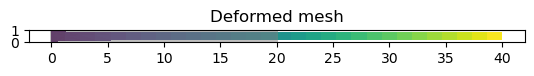

In [4]:
moved_mesh = Mesh(mesh)
ALE.move(moved_mesh, u)

# Plot deformed mesh
plot(u, title='Displacement', mode='displacement')
plot(mesh, alpha=0.5, title='Deformed mesh')

<function matplotlib.pyplot.title(label, fontdict=None, loc=None, pad=None, **kwargs)>

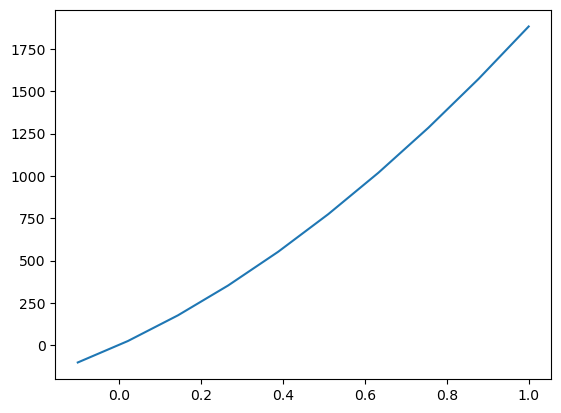

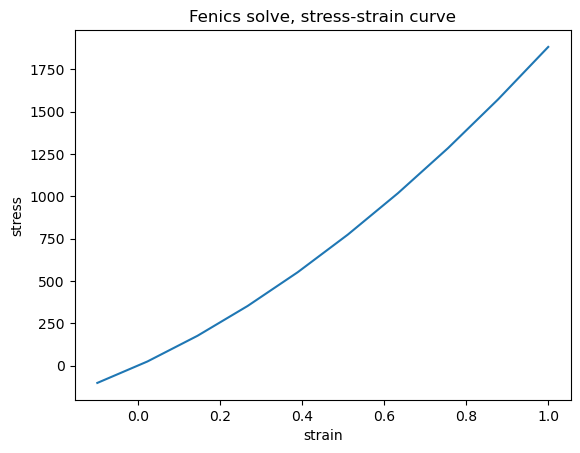

In [5]:

import matplotlib.pyplot as plt
plt.figure()
plt.plot(deformation_increment/(x_max-x_min), foce_on_right/1000)


plt.figure()
plt.plot(deformation_increment/(x_max-x_min), normal_stress_on_right/1000)
plt.xlabel('strain')
plt.ylabel('stress')
plt.title('Fenics solve, stress-strain curve')
plt.title

In [6]:
x_max

20.0

# Compare fenics and theory neo-hooken model

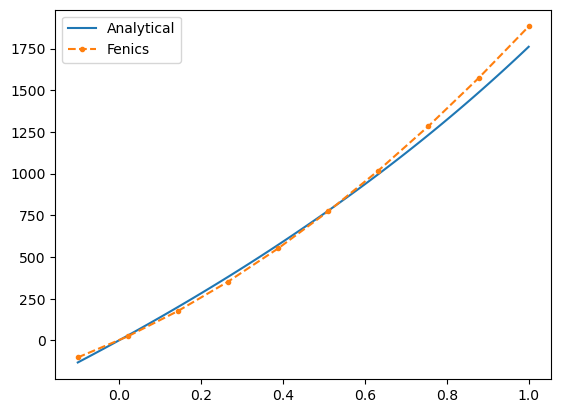

In [8]:
# Define strain range
strain = np.linspace(-0.1, 1, 100)
E = 1.e6  # Elastic modulus (replace with your value)
nu = 0.3  # Poisson's ratio (replace with your value)
mu = E / (2 * (1 + nu))
# lamda = E * nu / ((1 + nu) * (1 - 2 * nu))

mu, lmbda = (E/(2*(1 + nu))), (E*nu/((1 + nu)*(1 - 2*nu)))
# Calculate stress using Neo-Hookean model
stress = 2 * mu * strain + lmbda * (np.exp(strain) - 1)
plt.figure()
plt.plot(strain, stress/1000)
plt.plot(deformation_increment/(x_max-x_min), normal_stress_on_right/1000,'--.')
plt.legend(['Analytical', 'Fenics'])

